# Setup


In [ ]:
import os
from pathlib import Path

# --- ENVIRONMENT SWITCH ---
# Set to True if running on local machine with Google Drive Desktop mounted
# Set to False if running in Google Colab cloud
RUNNING_LOCALLY = True

if RUNNING_LOCALLY:
    # Standard macOS path for Google Drive Desktop
    BASE_PATH = Path('/Volumes/GoogleDrive/MyDrive/AI Public Trust')
else:
    # Google Colab cloud path
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/AI Public Trust')

# Pre-compute critical paths used across notebooks
twits_folder = BASE_PATH / 'Raw Data/Twits/'
test_folder = BASE_PATH / 'Raw Data/'
datasets_folder = BASE_PATH / 'Data Sets'
cleanedds_folder = BASE_PATH / 'Data Sets/Cleaned Data'
networks_folder = BASE_PATH / 'Data Sets/Networks/'
literature_folder = BASE_PATH / 'Literature/'
topic_models_folder = BASE_PATH / 'Models/Topic Modeling/'


In [1]:
# %%
# ──────────────────────────────────────────────────────────────────────────────
# 0. Environment & Imports
# ──────────────────────────────────────────────────────────────────────────────
from google.colab import drive
import os, re, json, glob, math, gc, sys
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# Plotting
import matplotlib.pyplot as plt

# Persistence
from joblib import dump, load
# import json, heapq, itertools
from collections import defaultdict
from tqdm import tqdm
import csv
import json, heapq, itertools, sys
from datetime import datetime, timezone
import re
from matplotlib.colors import Normalize


In [2]:
# %%
# ──────────────────────────────────────────────────────────────────────────────
# 1. Drive Mount & Paths
# ──────────────────────────────────────────────────────────────────────────────
drive.mount('/content/drive')

# Base project folder (Ignacio standard)
BASE = Path('/content/drive/My Drive/Colab Projects/AI Public Trust')
DATA_DIR = BASE / 'Data Sets' / 'Cleaned Data'

# Inputs
INPUT_JSONL = DATA_DIR / 'AItrust_pruned_twits_with_sentiment.json'

# Optional block writing (for very large corpora)
print('INPUT  :', INPUT_JSONL)

Mounted at /content/drive
INPUT  : /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data/AItrust_pruned_twits_with_sentiment.json


# Santity Check

In [3]:
# Check how it looks, LINE BY LINE
# CHECKING FOR TYPES OF TWEET THAT ARE NOT ORIGINAL
AItrust_twits_dict = open(INPUT_JSONL,'r',encoding='utf-8')

i = 0
for line in AItrust_twits_dict:
    twit = json.loads(line)
    #print(twit)
    try:
      i+=1
      print(twit.keys())
      print('\n')
      print(twit['text'])
      print('\n')
      print(twit['sentiment_label'])
      print('\n')
      print(twit['public_metrics'])
      print('------')
    except:
      pass
    #print('------')
    if i>2:
        break
AItrust_twits_dict.close()

dict_keys(['id', 'text', 'created_at', 'public_metrics', 'author_id', 'type', 'conversation_id', 'sentiment_label', 'sentiment_score'])


Hey 
you need perfect scores and completely AI proof content in your assignments and essays🤩🤩?
We are your best made decision this semester we handle:
✏MATLAB
✏Mathematics
✏Coding
✏Accounting/Finance
✏Web
✏Python
✏Tableau, Excel, SPSS Statistics


positive


{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0, 'impression_count': 11}
------
dict_keys(['id', 'text', 'created_at', 'public_metrics', 'author_id', 'type', 'referenced_tweets', 'conversation_id', 'referenced_tweets_dictionary', 'sentiment_label', 'sentiment_score'])


RT @lexfridman: Humans are an API to ChatGPT.
ChatGPT is an API to Python.
Python is an API to C.
C is an API to assembly.
Assembly is an A…


neutral


{'retweet_count': 7565, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}
------
dict_keys(['id', 'text', 'created_at', 'public_

# Clean Tweets

In [ ]:
query = '(ChatGPT OR Chat-GPT OR GPT OR GPT-3 OR GPT3 OR GPT-4 OR GPT4 OR BARD OR (Bing AI) OR LLMs OR LLM OR AI OR AGI OR (artificial intelligence) OR (large language models) OR LaMDA OR PaLM OR Med-PaLM OR BERT OR LLaMA) lang:en'


In [ ]:
OUTPUT_JSONL = DATA_DIR / 'AItrust_pruned_twits_with_sentiment_cleaned.json'

# Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', 'http', text)
    text = re.sub(r'@\w+', '@user', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = text.replace('\n', ' ')
    return text.strip()

# Get Top tweets for each topic

In [ ]:
K = 150
TOTAL_LINES = 22416373  # or None if unknown
LOG_BAD_LINES_TO = "bad_jsonl_lines.txt"
MAX_BAD_SAMPLES_IN_MEMORY = 5

_counter = itertools.count()
bad_lines = 0
bad_samples = []
skipped_non_original = 0

def safe_int(x, default=0):
    try:
        return int(x)
    except Exception:
        return default

top_heap = []                 # min-heap of (retweet_count, tie, tweet_dict)
ids_in_heap = set()           # prevent duplicates by tweet id

with open(INPUT_JSONL, "r", encoding="utf-8") as f, open(LOG_BAD_LINES_TO, "w", encoding="utf-8") as badlog:
    for line_no, line in enumerate(tqdm(f, total=TOTAL_LINES, desc="Processing tweets"), start=1):
        s = line.strip()
        if not s:
            continue

        # --- JSON decode guard ---
        try:
            tw = json.loads(s)
        except json.JSONDecodeError as e:
            bad_lines += 1
            badlog.write(f"[line {line_no}] JSONDecodeError: {e.msg} at pos {e.pos}\n")
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:500]))
            continue
        except Exception as e:
            bad_lines += 1
            badlog.write(f"[line {line_no}] Generic decode error: {repr(e)}\n")
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:500]))
            continue

        # --- Keep ONLY original tweets ---
        if (tw.get("type") or "").strip().lower() != "original":
            skipped_non_original += 1
            continue

        tw_id = tw.get("id")
        if tw_id is None or tw_id in ids_in_heap:
            continue

        rt = safe_int((tw.get("public_metrics") or {}).get("retweet_count", 0), 0)

        # Compact record for output
        tw_min = {
            "id": tw_id,
            "text": tw.get("text"),
            "created_at": tw.get("created_at"),
            "author_id": tw.get("author_id"),
            "retweet_count": rt,
            "type": "original",
        }

        item = (rt, next(_counter), tw_min)

        if len(top_heap) < K:
            heapq.heappush(top_heap, item)
            ids_in_heap.add(tw_id)
        elif rt > top_heap[0][0]:
            popped = heapq.heapreplace(top_heap, item)
            popped_id = popped[2].get("id")
            if popped_id in ids_in_heap:
                ids_in_heap.remove(popped_id)
            ids_in_heap.add(tw_id)
        # else: not in top-K, ignore

# --- Final top-K, sorted by retweets desc
top_k_originals = [tw for (_, _, tw) in sorted(top_heap, key=lambda x: x[0], reverse=True)]

# Example: print brief summary
print(f"Top {len(top_k_originals)} original tweets by retweets:")
for i, tw in enumerate(top_k_originals, 1):
    print(f"{i:>3}. RTs={tw['retweet_count']:>6}  id={tw['id']}  {tw['text'][:80]!r}")

# Optional: brief report
if bad_lines or skipped_non_original:
    if bad_lines:
        print(f"\nSkipped {bad_lines} malformed lines. First {len(bad_samples)} samples:")
        for ln, sample in bad_samples:
            preview = sample[:200].replace("\n", " ")
            print(f"  - line {ln}: {preview}...")
        print(f"(Full log saved to {LOG_BAD_LINES_TO})")
    print(f"Skipped {skipped_non_original:,} non-original tweets.")

In [ ]:
K = 150
TOTAL_LINES = 22416373  # or None if unknown
LOG_BAD_LINES_TO = "bad_jsonl_lines.txt"
MAX_BAD_SAMPLES_IN_MEMORY = 5

# per-topic min-heaps of (retweet_count, tie_breaker, tweet_dict)
heaps = defaultdict(list)
# track tweet IDs currently inside each topic heap (prevents dupes in results)
heap_ids = defaultdict(set)

_counter = itertools.count()
bad_lines = 0
bad_samples = []
skipped_non_original = 0

def safe_int(x, default=0):
    try:
        return int(x)
    except Exception:
        return default

with open(INPUT_JSONL, "r", encoding="utf-8") as f, open(LOG_BAD_LINES_TO, "w", encoding="utf-8") as badlog:
    for line_no, line in enumerate(tqdm(f, total=TOTAL_LINES, desc="Processing tweets"), start=1):
        s = line.strip()
        if not s:
            continue

        # --- JSON decode guard ---
        try:
            tw = json.loads(s)
        except json.JSONDecodeError as e:
            bad_lines += 1
            badlog.write(f"[line {line_no}] JSONDecodeError: {e.msg} at pos {e.pos}\n")
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:500]))
            continue
        except Exception as e:
            bad_lines += 1
            badlog.write(f"[line {line_no}] Generic decode error: {repr(e)}\n")
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:500]))
            continue

        # --- Keep ONLY original tweets ---
        if (tw.get("type") or "").strip().lower() != "original":
            skipped_non_original += 1
            continue

        # --- Extract fields safely ---
        topic = tw.get("lda_k5_topic_label") or "Unknown"
        pm = tw.get("public_metrics") or {}
        rt = safe_int(pm.get("retweet_count", 0), 0)
        tw_id = tw.get("id")

        # Skip if this exact original is already in the heap for this topic
        if tw_id in heap_ids[topic]:
            continue

        # Compact record for output
        tw_min = {
            "id": tw_id,
            "text": tw.get("text"),
            "created_at": tw.get("created_at"),
            "author_id": tw.get("author_id"),
            "retweet_count": rt,
            "sentiment_label": tw.get("sentiment_label"),
            "lda_k5_topic_label": topic,
            "type": "original",
        }

        # --- Maintain top-K per topic (min-heap) ---
        h = heaps[topic]
        ids_in_heap = heap_ids[topic]
        item = (rt, next(_counter), tw_min)

        if len(h) < K:
            heapq.heappush(h, item)
            if tw_id is not None:
                ids_in_heap.add(tw_id)
        elif rt > h[0][0]:
            popped = heapq.heapreplace(h, item)  # returns (rt, tie, popped_rec)
            # remove popped id from the set, add new id
            popped_id = popped[2].get("id")
            if popped_id in ids_in_heap:
                ids_in_heap.remove(popped_id)
            if tw_id is not None:
                ids_in_heap.add(tw_id)
        # else: new item not better than current min -> ignore

# Build the final dictionary: topic -> list of tweet dicts sorted by retweets desc
top_by_topic = {
    topic: [tw for (rt, _, tw) in sorted(h, key=lambda x: x[0], reverse=True)]
    for topic, h in heaps.items()
}

# Optional: brief report
if bad_lines or skipped_non_original:
    if bad_lines:
        print(f"\nSkipped {bad_lines} malformed lines. First {len(bad_samples)} samples:")
        for ln, sample in bad_samples:
            preview = sample[:200].replace("\n", " ")
            print(f"  - line {ln}: {preview}...")
        print(f"(Full log saved to {LOG_BAD_LINES_TO})")
    print(f"Skipped {skipped_non_original:,} non-original tweets.")

Processing tweets:  96%|█████████▌| 21466173/22416373 [16:07<00:42, 22198.32it/s]


Skipped 1 malformed lines. First 1 samples:
  - line 21466173: {"id": "1599065938435149824", "text": "There's one thing about AI that makes me sad.\n\nWhen I have problem with my car - I always first ask my friend who loves cars knowing I'd instantly find the ans...
(Full log saved to bad_jsonl_lines.txt)
Skipped 12,537,708 non-original tweets.


In [ ]:
OUT_CSV = DATA_DIR / f"top_retweets_by_topic_{K}.csv"

# Flatten top_by_topic into list of dicts
rows = [
    {
        "topic_label": tw.get("lda_k5_topic_label"),
        "sentiment_label": tw.get("sentiment_label"),
        "retweet_count": tw.get("retweet_count", 0),
        "text": tw.get("text", "").replace("\n", " "),
    }
    for topic, tweets in top_by_topic.items()
    for tw in tweets
]

# Create DataFrame
df = pd.DataFrame(rows)

# Save to CSV directly with pandas
df.to_csv(OUT_CSV, index=False, encoding="utf-8")

# Preview
print(f"CSV saved to {OUT_CSV}")
print(df.head())

CSV saved to /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data/top_retweets_by_topic_100.csv
  topic_label sentiment_label  retweet_count  \
0     Topic 0         neutral          79224   
1     Topic 0         neutral          70000   
2     Topic 0        positive          61777   
3     Topic 0        positive          57647   
4     Topic 0         neutral          56660   

                                                text  
0  KAI 카이 The 3rd Mini Album 〖Rover〗  ➫ 2023.03.1...  
1  KAI 카이 The 3rd Mini Album 〖Rover〗 Schedule Pos...  
2  🚨SURPRISE WHITELIST DROP🚨  Gabe has VERY KINDL...  
3  Before I go to bed, I wanted to say this. I lo...  
4  เห็นยาชุดแบบนี้เริ่มกลับมาระบาดอีกละ จะบอกกับท...  


# Topics in Time

In [ ]:
TOTAL_LINES = 22416373  # or None if you don’t know exact count
LOG_BAD_LINES_TO = "bad_jsonl_lines_topics.txt"
MAX_BAD_SAMPLES_IN_MEMORY = 5

# Accumulator: date_str (YYYY-MM-DD) -> 5-element list of cumulative weights
by_day = defaultdict(lambda: [0.0] * 5)

bad_lines = 0
bad_samples = []

def parse_date_to_utc_day(s):
    """Parse 'created_at' -> 'YYYY-MM-DD' in UTC, fallback to string slice if needed."""
    if not s:
        return None
    try:
        if s.endswith("Z"):
            dt = datetime.fromisoformat(s.replace("Z", "+00:00"))
        else:
            dt = datetime.fromisoformat(s)
            if dt.tzinfo is None:
                dt = dt.replace(tzinfo=timezone.utc)
        dt_utc = dt.astimezone(timezone.utc)
        return dt_utc.date().isoformat()
    except Exception:
        if len(s) >= 10 and s[4] == "-" and s[7] == "-":
            return s[:10]
        return None

with open(INPUT_JSONL, "r", encoding="utf-8") as f, open(LOG_BAD_LINES_TO, "w", encoding="utf-8") as badlog:
    for line_no, line in enumerate(tqdm(f, total=TOTAL_LINES, desc="Aggregating topic weights"), start=1):
        s = line.strip()
        if not s:
            continue

        # --- JSON decode guard ---
        try:
            tw = json.loads(s)
        except json.JSONDecodeError as e:
            bad_lines += 1
            msg = f"[line {line_no}] JSONDecodeError: {e.msg} at pos {e.pos}\n"
            badlog.write(msg)
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:200]))
            continue
        except Exception as e:
            bad_lines += 1
            msg = f"[line {line_no}] Generic decode error: {repr(e)}\n"
            badlog.write(msg)
            if len(bad_samples) < MAX_BAD_SAMPLES_IN_MEMORY:
                bad_samples.append((line_no, s[:200]))
            continue

        # --- Parse created_at and topic distribution ---
        day = parse_date_to_utc_day(tw.get("created_at"))
        dist = tw.get("lda_k5_topic_dist")

        if day is None or not isinstance(dist, (list, tuple)) or len(dist) != 5:
            continue  # skip malformed

        # --- Aggregate topic weights ---
        agg = by_day[day]
        for i in range(5):
            try:
                agg[i] += float(dist[i])
            except (TypeError, ValueError):
                pass

# Build DataFrame
df_topics_daily = (
    pd.DataFrame
    .from_dict(by_day, orient="index", columns=[f"Topic {i}" for i in range(5)])
    .sort_index()
    .reset_index()
    .rename(columns={"index": "date"})
)

# Compute shares
row_sums = df_topics_daily[[f"Topic {i}" for i in range(5)]].sum(axis=1)
df_topics_daily_shares = df_topics_daily.copy()
for i in range(5):
    df_topics_daily_shares[f"Topic {i} Share"] = (
        df_topics_daily_shares[f"Topic {i}"] / row_sums.replace(0, pd.NA)
    )
df_topics_daily_shares = df_topics_daily_shares[["date"] + [f"Topic {i} Share" for i in range(5)]]

# Save to CSV
OUT_CSV = "topics_in_time.csv"
df_topics_daily.to_csv(OUT_CSV, index=False, encoding="utf-8")

print(df_topics_daily.head())
print(df_topics_daily_shares.head())

# Report bad lines
if bad_lines:
    print(f"\nSkipped {bad_lines} malformed lines. First {len(bad_samples)} samples:")
    for ln, sample in bad_samples:
        preview = sample.replace("\n", " ")
        print(f"  - line {ln}: {preview}...")
    print(f"(Full log saved to {LOG_BAD_LINES_TO})")

Aggregating topic weights:  96%|█████████▌| 21466173/22416373 [15:04<00:40, 23735.21it/s]


         date     Topic 0     Topic 1     Topic 2     Topic 3     Topic 4
0  2022-10-31  333.772199   54.244690  337.818188  178.149125   93.015798
1  2022-11-01  798.189561  565.055598  139.013247  252.413359  137.328235
2  2022-11-02  649.382237   98.108604  132.272336  243.853880  141.382943
3  2022-11-03  734.658866  110.382723  234.679136  347.641449  108.637826
4  2022-11-04  765.788743   87.681344  256.425445  257.283521  111.820947
         date  Topic 0 Share  Topic 1 Share  Topic 2 Share  Topic 3 Share  \
0  2022-10-31       0.334777       0.054408       0.338835       0.178685   
1  2022-11-01       0.421876       0.298655       0.073474       0.133411   
2  2022-11-02       0.513346       0.077556       0.104563       0.192770   
3  2022-11-03       0.478294       0.071864       0.152786       0.226329   
4  2022-11-04       0.517775       0.059284       0.173378       0.173958   

   Topic 4 Share  
0       0.093296  
1       0.072584  
2       0.111765  
3       0.070728 

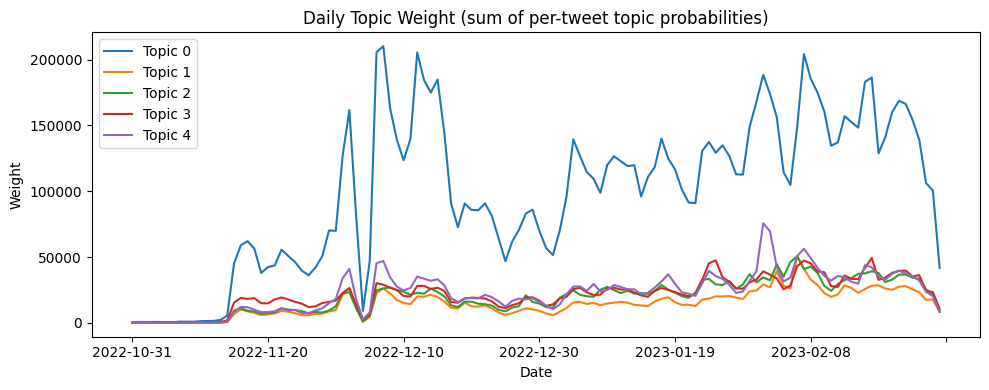

In [ ]:
ax = df_topics_daily.set_index("date")[ [f"Topic {i}" for i in range(5)] ].plot(figsize=(10,4))
ax.set_title("Daily Topic Weight (sum of per-tweet topic probabilities)")
ax.set_xlabel("Date")
ax.set_ylabel("Weight")
plt.tight_layout()
plt.show()

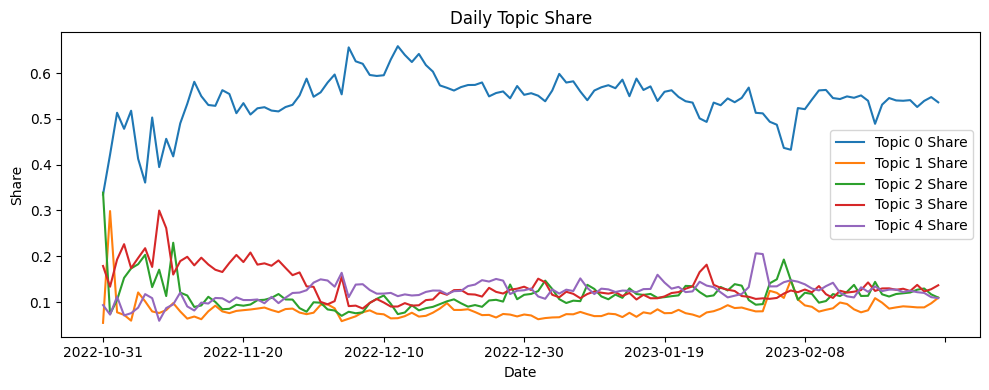

In [ ]:
ax = df_topics_daily_shares.set_index("date")[ [f"Topic {i} Share" for i in range(5)] ].plot(figsize=(10,4))
ax.set_title("Daily Topic Share")
ax.set_xlabel("Date")
ax.set_ylabel("Share")
plt.tight_layout()
plt.show()

In [ ]:
weekly = (df_topics_daily
          .assign(date=pd.to_datetime(df_topics_daily["date"]))
          .set_index("date")
          .resample("W").sum()
          .reset_index())
print(weekly.head())

        date        Topic 0       Topic 1       Topic 2        Topic 3  \
0 2022-11-06    4427.597420   1244.158531   1676.418074    1897.431921   
1 2022-11-13    9553.644150   1515.421441   2681.646603    3982.615115   
2 2022-11-20  308607.287235  46659.191940  53826.851329  103534.755108   
3 2022-11-27  314499.918176  50768.021200  63712.798565  110309.160085   
4 2022-12-04  569562.904670  86118.038207  88024.184739  113860.386547   

         Topic 4  
0     900.394054  
1    1791.672691  
2   59877.914387  
3   64066.101974  
4  140107.485836  


# Topic and Sentiment

In [ ]:
# Prepare containers
counts = defaultdict(Counter)   # hard: {topic_label: Counter({sentiment: count})}
wcounts = defaultdict(Counter)  # soft: {topic_label: Counter({sentiment: weight_sum})}

# Topic index -> label string (adjust K if needed)
K = 5
topic_names = {i: f"Topic {i}" for i in range(K)}

def safe_float(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default

with open(INPUT_JSONL, "r", encoding="utf-8") as f:
    for line in tqdm(f, total=TOTAL_LINES, desc="Counting sentiment per topic (hard+soft)"):
        s = line.strip()
        if not s:
            continue
        try:
            tw = json.loads(s)
        except Exception:
            continue

        # Common pieces
        sentiment = tw.get("sentiment_label") or "unknown"

        # --- Hard (single-topic label) ---
        topic_label = tw.get("lda_k5_topic_label") or "Unknown"
        counts[topic_label][sentiment] += 1

        # --- Soft (distribution over topics) ---
        dist = tw.get("lda_k5_topic_dist")
        if isinstance(dist, (list, tuple)) and len(dist) == K:
            for i, w in enumerate(dist):
                wcounts[topic_names[i]][sentiment] += safe_float(w)

Counting sentiment per topic (hard+soft):  96%|█████████▌| 21466173/22416373 [14:50<00:39, 24103.76it/s]


/tmp/ipython-input-2826108452.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


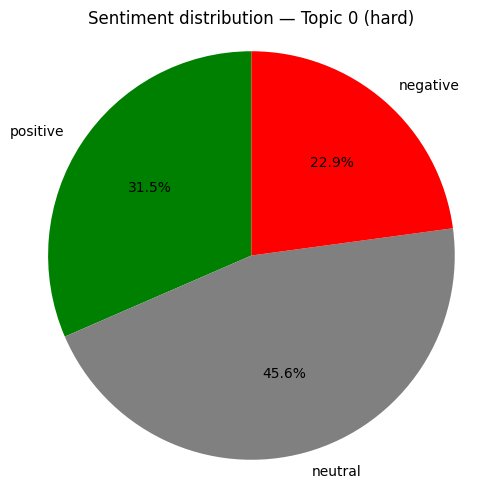

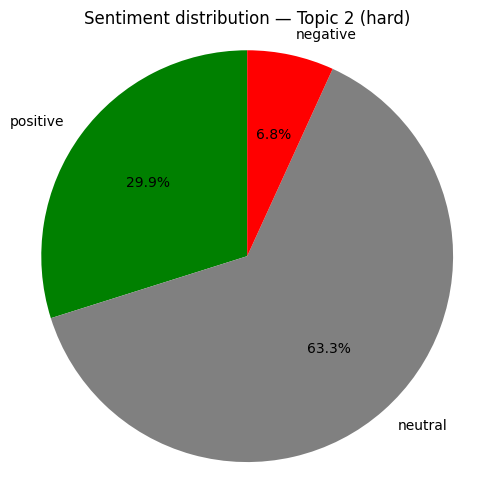

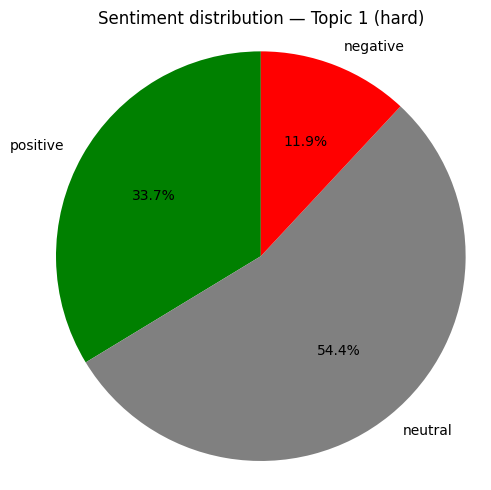

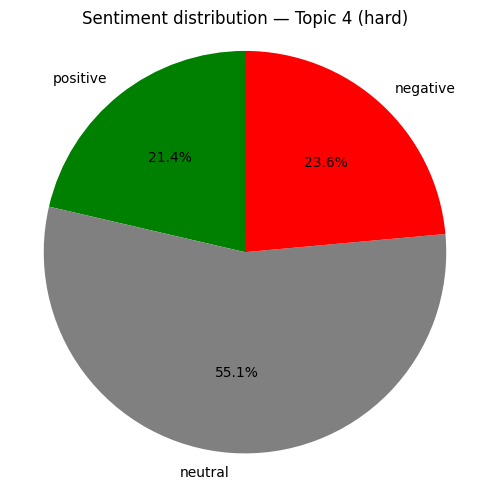

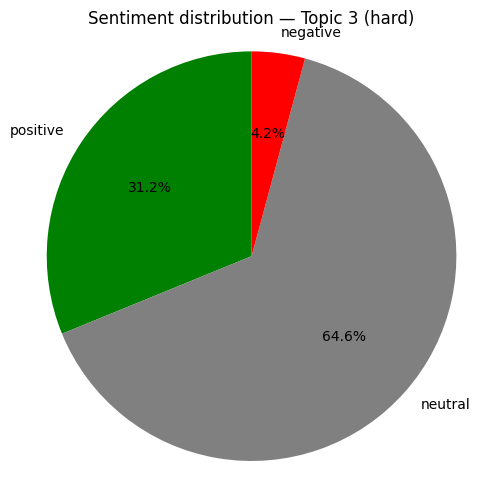

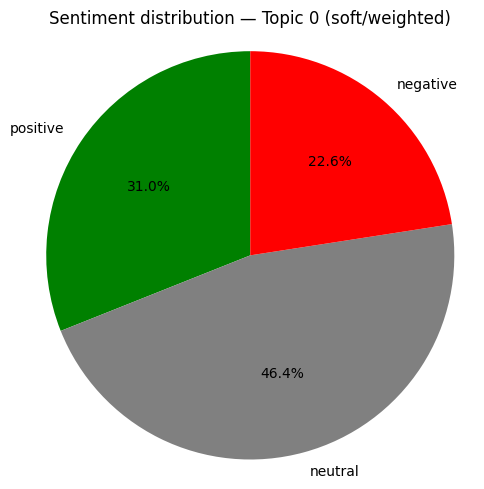

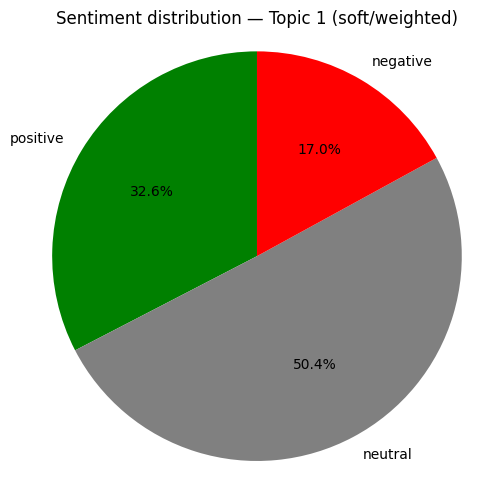

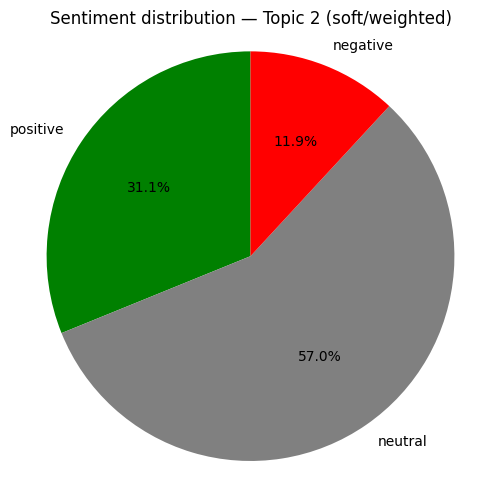

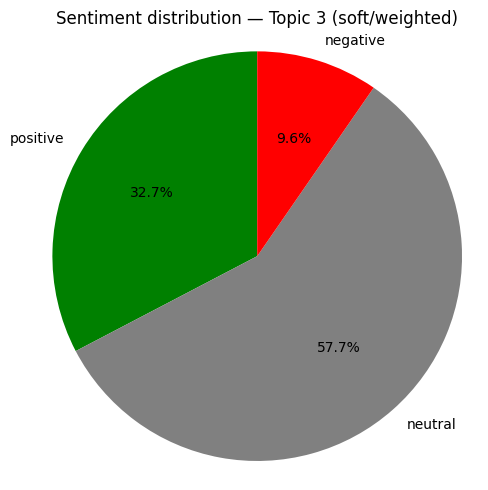

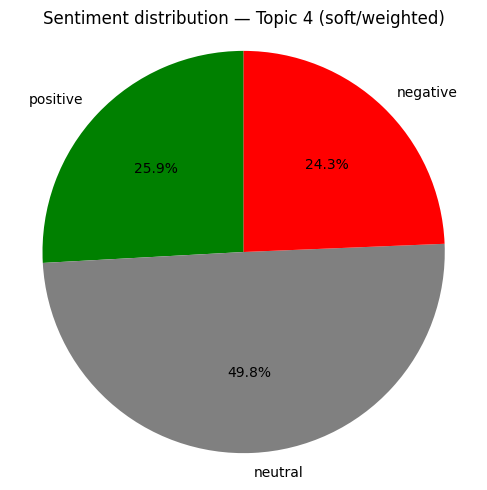

HARD head:
     topic sentiment    count
0  Topic 0  positive  4867664
1  Topic 0   neutral  7051674
2  Topic 0  negative  3534272
3  Topic 2  positive   484291
4  Topic 2   neutral  1026578

SOFT head:
     topic sentiment        weight
0  Topic 0  positive  3.691408e+06
1  Topic 0   neutral  5.520332e+06
2  Topic 0  negative  2.682798e+06
3  Topic 1  positive  5.823908e+05
4  Topic 1   neutral  8.995757e+05


In [ ]:
# 1) Build a global, stable sentiment order across both dicts
all_sentiments = set()
for d in (counts, wcounts):
    for _topic, ctr in d.items():
        all_sentiments.update(ctr.keys())

# Put common sentiments first, then any others in alpha order
canonical = ["positive", "neutral", "negative", "unknown"]
sentiment_order = [s for s in canonical if s in all_sentiments] + \
                  sorted(s for s in all_sentiments if s not in canonical)

# 2) Consistent colors per sentiment
# Prefer fixed colors for common labels; fallback to tab10 for any extras
known_colors = {
    "positive": "green",
    "neutral": "gray",
    "negative": "red",
    "unknown": "lightgray",
}
cmap = plt.cm.get_cmap("tab10")
sentiment_colors = {}
for i, s in enumerate(sentiment_order):
    sentiment_colors[s] = known_colors.get(s, cmap(i % 10))

def plot_pies(data_dict, title_suffix):
    """Plot one pie per topic from a {topic: Counter(sentiment -> value)} dict,
    using fixed sentiment order and colors."""
    for topic, ctr in data_dict.items():
        # Ensure fixed order & include zeros for missing sentiments
        labels = sentiment_order
        sizes = [float(ctr.get(lbl, 0.0)) for lbl in labels]

        # Skip empty plots where everything is zero
        if not any(sizes):
            continue

        colors = [sentiment_colors[lbl] for lbl in labels]

        plt.figure(figsize=(5, 5))
        plt.title(f"Sentiment distribution — {topic} ({title_suffix})")
        plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
        plt.axis("equal")
        plt.tight_layout()
        plt.show()

# 3) Plot both sets with aligned colors/order
plot_pies(counts, "hard")
plot_pies(wcounts, "soft/weighted")

# 4) Tidy DataFrames (aligned order, including zeros if you want them present)
rows_hard = []
for t, ctr in counts.items():
    for s in sentiment_order:
        v = int(ctr.get(s, 0))
        if v:  # change to `if True` to keep zero rows
            rows_hard.append({"topic": t, "sentiment": s, "count": v})
df_topic_sentiment_hard = pd.DataFrame(rows_hard)

rows_soft = []
for t, ctr in wcounts.items():
    for s in sentiment_order:
        v = float(ctr.get(s, 0.0))
        if v:  # change to `if True` to keep zero rows
            rows_soft.append({"topic": t, "sentiment": s, "weight": v})
df_topic_sentiment_soft = pd.DataFrame(rows_soft)

print("HARD head:")
print(df_topic_sentiment_hard.head())
print("\nSOFT head:")
print(df_topic_sentiment_soft.head())

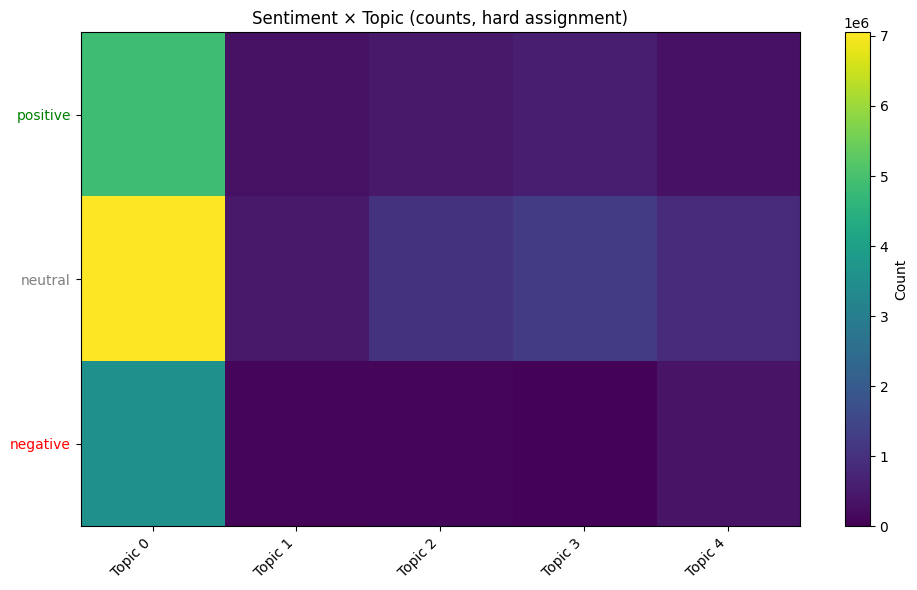

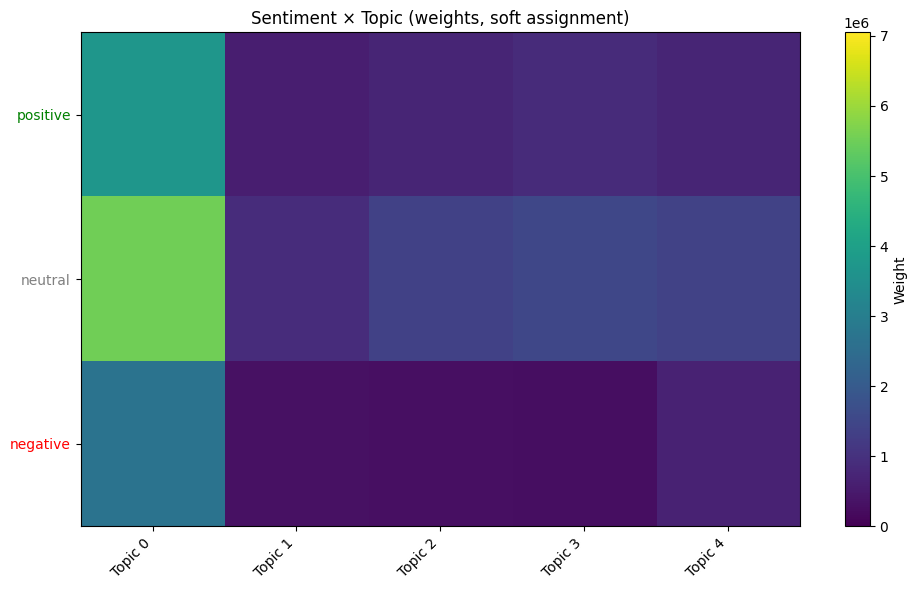

In [ ]:
# --- Helpers: consistent ordering ---
def topic_key(name):
    if isinstance(name, str) and name.lower().startswith("topic "):
        try:
            n = int(re.findall(r"\d+", name)[0])
            return (1, n)  # put numbered topics after "Unknown"
        except Exception:
            return (2, name)
    if str(name).lower() == "unknown":
        return (0, -1)
    return (2, str(name))

all_topics = sorted(
    set(df_topic_sentiment_hard["topic"]).union(df_topic_sentiment_soft["topic"]),
    key=topic_key
)

# Ensure both pivots cover the same sentiments & topics
pivot_hard = (
    df_topic_sentiment_hard
    .pivot_table(index="sentiment", columns="topic", values="count", fill_value=0)
    .reindex(index=sentiment_order, columns=all_topics, fill_value=0)
)

pivot_soft = (
    df_topic_sentiment_soft
    .pivot_table(index="sentiment", columns="topic", values="weight", fill_value=0.0)
    .reindex(index=sentiment_order, columns=all_topics, fill_value=0.0)
)

# --- Shared colormap scaling (optional but useful for comparison) ---
# If you prefer independent scaling, set `shared_norm = None` and remove `norm=shared_norm`.
vmax = max(pivot_hard.to_numpy().max(), pivot_soft.to_numpy().max())
shared_norm = Normalize(vmin=0, vmax=vmax)

def color_yticks(ax):
    for tick in ax.get_yticklabels():
        s = tick.get_text()
        tick.set_color(sentiment_colors.get(s, "black"))

# --- Plot HARD ---
plt.figure(figsize=(10, 6))
plt.title("Sentiment × Topic (counts, hard assignment)")
im = plt.imshow(pivot_hard.values, aspect="auto", norm=shared_norm)
plt.xticks(range(pivot_hard.shape[1]), pivot_hard.columns, rotation=45, ha="right")
plt.yticks(range(pivot_hard.shape[0]), pivot_hard.index)
color_yticks(plt.gca())
cbar = plt.colorbar(im)
cbar.set_label("Count")
plt.tight_layout()
plt.show()

# --- Plot SOFT ---
plt.figure(figsize=(10, 6))
plt.title("Sentiment × Topic (weights, soft assignment)")
im = plt.imshow(pivot_soft.values, aspect="auto", norm=shared_norm)
plt.xticks(range(pivot_soft.shape[1]), pivot_soft.columns, rotation=45, ha="right")
plt.yticks(range(pivot_soft.shape[0]), pivot_soft.index)
color_yticks(plt.gca())
cbar = plt.colorbar(im)
cbar.set_label("Weight")
plt.tight_layout()
plt.show()